In [1]:
import sys
sys.path.insert(0, r'../../quetzal/')
import syspy

import geopandas as gpd
ipath = r'inputs/'

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 10)

## Clustering

In [3]:
nodes = gpd.read_file(ipath + r'nodes.geojson', driver='GeoJSON')
print(len(nodes))
nodes.head(2)

1056


,index,stop_name,geometry
0,node_CHAMF-E,CHAMPFLEUR,POINT (436223.58770 6715001.59700)
1,node_MENDES-E,MENDES FRANCE,POINT (433029.20374 6714060.18372)


TODO: Explorer la couche nodes avec QGIS

<AxesSubplot: >

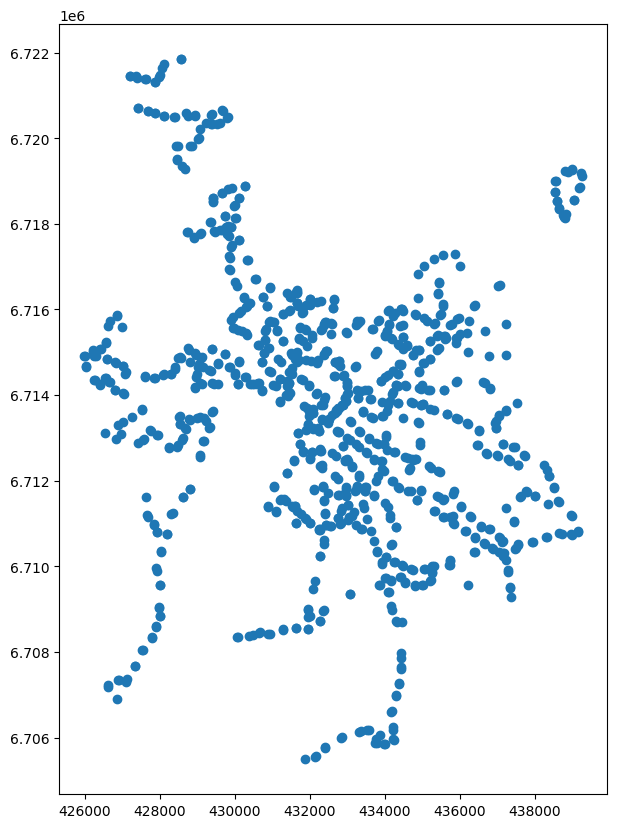

In [4]:
nodes.plot()

### KMeans clustering

In [5]:
from syspy.spatial import spatial
spatial.zone_clusters??

Signature:
spatial.zone_clusters(
    zones,
    n_clusters=10,
    buffer=None,
    cluster_column=None,
    geo_union_method=<function union_geometry at 0x000001553E1CB0D0>,
    geo_join_method=<function <lambda> at 0x000001553E1CB280>,
)
Docstring: <no docstring>
Source:   
def zone_clusters(
    zones,
    n_clusters=10,
    buffer=None,
    cluster_column=None,
    geo_union_method=union_geometry,
    geo_join_method=lambda g: g.convex_hull
):
    n_clusters = min(n_clusters, len(zones))

    df = gpd.GeoDataFrame(add_centroid(zones))

    if buffer:
        df['geometry'] = df['geometry'].apply(lambda g: g.buffer(buffer))
    x = df[['longitude', 'latitude']].values

    if cluster_column:
        cluster_series = df['cluster'] = df[cluster_column]
    else:
        y_pred = KMeans(n_clusters=n_clusters, random_state=1).fit_predict(x)
        cluster_series = df['cluster'] = pd.Series(y_pred, index=df.index)

    cluster_series.name = 'cluster'

    geo = df.dissolve('cluster')['

In [6]:
# KMeans clustering
clusters, cluster_series = spatial.zone_clusters(
    nodes,
    n_clusters=512,
    geo_join_method=lambda g: g.centroid
)

In [7]:
cluster_series

0        32
1       504
2        56
3       171
4       409
       ... 
1051    252
1052    427
1053     48
1054    374
1055    421
Name: cluster, Length: 1056, dtype: int32

<AxesSubplot: >

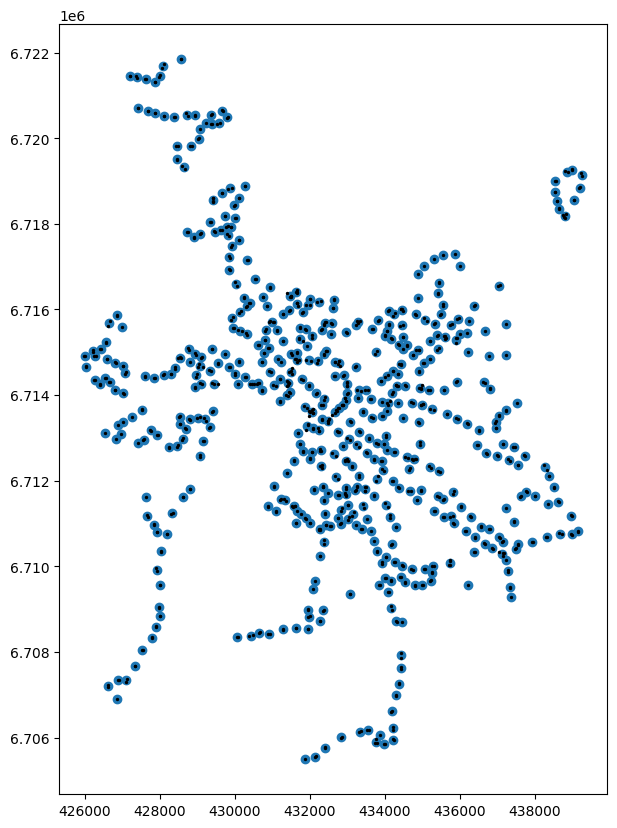

In [8]:
ax = gpd.GeoDataFrame(clusters).plot()
nodes.plot(ax=ax, markersize=2, color='k')

In [9]:
gpd.GeoDataFrame(clusters).to_file(ipath + r'clusters.geojson', driver='GeoJSON')

In [10]:
cluster_series

0        32
1       504
2        56
3       171
4       409
       ... 
1051    252
1052    427
1053     48
1054    374
1055    421
Name: cluster, Length: 1056, dtype: int32

### Agglomerative clustering

In [11]:
spatial.agglomerative_clustering??

Signature: spatial.agglomerative_clustering(stops, distance_threshold=150)
Source:   
def agglomerative_clustering(
    stops,
    distance_threshold=150,
):
    """
    Stops must be in a metric cartesian coordinate system.
    """
    df = gpd.GeoDataFrame(stops).copy()
    df['x'] = df.geometry.x
    df['y'] = df.geometry.y
    c = AgglomerativeClustering(
        n_clusters=None,
        distance_threshold=distance_threshold
    ).fit(df[['x', 'y']].values)
    return c.labels_
File:      c:\users\rgoix\documents\dev\formation\quetzal\syspy\spatial\spatial.py
Type:      function


In [12]:
nodes['cluster_id'] = spatial.agglomerative_clustering(
    nodes,
    distance_threshold=150
)

In [13]:
nodes['cluster_id'].nunique()

512

In [14]:
clusters = nodes.dissolve('cluster_id')
clusters.geometry = clusters.centroid
clusters.to_file(ipath + r'clusters_agg.geojson', driver='GeoJSON')

C:\Users\rgoix\AppData\Local\Temp\ipykernel_10048\3292073562.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clusters.geometry = clusters.centroid


<AxesSubplot: >

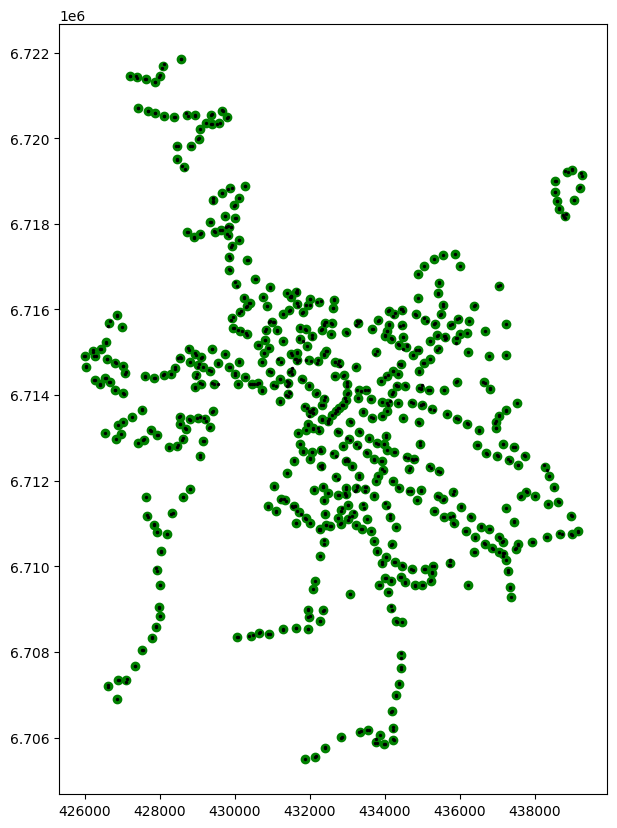

In [15]:
ax = clusters.plot(color='g')
nodes.plot(ax=ax, markersize=2, color='k')

<font color='#D22328'>
# Exercice
</font>

For each method, create the parenthood LineString between nodes and centroids and display on QGis